In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# --------------------
# IMPORTS
# --------------------
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import xgboost as xgb

from importlib import reload
from xgboost import plot_importance

#import eda
#reload(eda)

# --------------------
# CONSTANTS
# --------------------
PATH = '/content/drive/My Drive/Colab Notebooks/ocr_data_scientist/P7 Modèle de scoring/'
os.chdir(PATH)
MODEL_PATH = 'fitted_xgb.pkl'

# --------------------
# LOAD
# --------------------
# model
model = pickle.load(open(MODEL_PATH, 'rb'))

# data
app_train_df = pd.read_csv(PATH + 'data/application_train.csv',
                           sep=',')
train_df = pd.read_csv(PATH + 'data/app_train.csv', sep=',') # à mettre en cash dans dashboard.py ?
test_df = pd.read_csv(PATH + 'data/app_test.csv', sep=',') # à mettre en cash dans dashboard.py ?
train_df.set_index('SK_ID_CURR', inplace=True)
test_df.set_index('SK_ID_CURR', inplace=True)

In [3]:
test_df.head(5)

,CNT_CHILDREN,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LIVINGAPARTMENTS_MEDI,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,...,log_CNT_INSTALMENT_prev,log_NAME_CONTRACT_TYPE_prev_Consumer_loans,log_NAME_CONTRACT_TYPE_prev_Cash_loans,log_NAME_YIELD_GROUP_middle,log_NAME_YIELD_GROUP_low_normal,log_NAME_YIELD_GROUP_high,log_NAME_SELLER_INDUSTRY_Consumer_electronics,log_CHANNEL_TYPE_Country-wide,log_NAME_PORTFOLIO_POS,log_AMT_INCOME_TOTAL,log_AMT_CREDIT,log_AMT_GOODS_PRICE,log_DAYS_EMPLOYED,log_DAYS_REGISTRATION,log_AMT_REQ_CREDIT_BUREAU_YEAR,log_AMT_ANNUITY,log_AMT_APPLICATION,log_AMT_CREDIT_prev,log_AMT_GOODS_PRICE_prev,log_HOUR_APPR_PROCESS_START_prev,log_NFLAG_LAST_APPL_IN_DAY,log_RATE_DOWN_PAYMENT,log_CNT_PAYMENT,log_AMT_ANNUITY_prev,log_NAME_CONTRACT_STATUS_Approved_inter,log_NAME_TYPE_SUITE_Unaccompanied_prev,log_NAME_CLIENT_TYPE_New,log_NAME_CLIENT_TYPE_Repeater,log_NAME_PAYMENT_TYPE_Cash_through_the_bank,log_BASEMENTAREA_MEDI,log_COMMONAREA_MEDI,log_LANDAREA_MEDI,log_LIVINGAREA_MEDI,log_NONLIVINGAREA_MEDI,log_RATE_INTEREST_PRIVILEGED,log_DAYS_FIRST_DRAWING,log_DAYS_DECISION,log_MONTHS_BALANCE_inter,log_MONTHS_BALANCE_prim_prev,log_AMT_DIFF
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,0.00,0.257380,0.333427,0.872086,0.159271,1.0,0.0,1.0,0.0,1.0,0.05,0.5,0.75,0.782609,0.0,0.0,0.0,0.0,0.0,0.0,0.798496,0.923573,0.180263,0.0666,0.9732,0.7585,0.00,0.1379,0.1250,0.2083,0.0770,0.0,0.601009,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.339859,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.316128,0.648811,0.588893,0.540431,0.925377,0.000000,0.502275,0.126355,0.121550,0.126355,0.314970,0.000000,0.761701,0.153648,0.180513,0.000000,0.000000,0.00000,0.253678,0.000000,0.692713,0.587076,0.672105,0.677741,0.372840,0.000000,0.713008,0.000046,0.000330,1.000000,0.000017
100005,0.00,0.491855,0.399339,0.744329,0.159271,1.0,0.0,1.0,0.0,0.0,0.05,0.5,0.75,0.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.595809,0.341118,0.490287,0.0926,0.9816,0.7585,0.00,0.1379,0.1667,0.2083,0.0770,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.540258,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.255289,0.409069,0.354549,0.518741,0.852741,0.387762,0.463647,0.196083,0.182763,0.196083,0.395668,0.159571,0.764324,0.350198,0.207632,0.000000,0.000000,0.00000,0.000000,0.000000,0.722745,0.587076,0.672105,0.722465,0.372840,0.159571,0.756942,0.000051,0.000350,1.000000,0.000017
100013,0.00,0.260854,0.288794,0.448173,0.067568,1.0,0.0,1.0,0.0,0.0,0.05,0.5,0.75,0.608696,0.0,0.0,0.0,0.0,0.0,0.0,0.526876,0.818464,0.692134,0.0926,0.9816,0.7585,0.00,0.1379,0.1667,0.2083,0.0770,0.0,0.803715,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.754018,0.179052,0.165443,0.19824,0.0,0.0,0.000000,0.000000,0.185449,0.395662,0.688106,0.674947,0.518862,0.970808,0.489301,0.782186,0.489158,0.495870,0.489158,0.566618,0.319143,0.776993,0.489017,0.477960,0.373114,0.194959,0.00000,0.320106,0.279415,0.722745,0.587076,0.672105,0.722465,0.372840,0.319143,0.804528,0.000038,0.000212,1.000000,0.000017
100028,0.10,0.361760,0.628269,0.337114,0.159271,1.0,0.0,1.0,1.0,0.0,0.15,0.5,0.75,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,0.553401,0.596114,0.694076,0.3081,0.9970,0.9597,0.32,0.2759,0.3750,0.0417,0.2446,0.0,0.586104,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.731433,0.283791,0.000000,0.00000,0.0,0.0,0.221065,0.276708,0.185449,0.482331,0.909291,0.909291,0.544718,0.973263,0.387762,

In [4]:
test_id = 100005

In [5]:
# --------------------
# SETTINGS
# --------------------
# Get the candidate's row # à mettre en cash dans dashboard.py ?
row = test_df.loc[test_id]


# --------------------
# GENERAL EVALUATION
# --------------------
def solvability_score(test_df, model, row):
    '''
    Return the probability in % for the sample to be attributed the note 1.
    model must be already fitted to the train set.
    '''
    # Solution de départ
    temp_df = test_df.copy()
    # Add the new row
    temp_df.iloc[temp_df.shape[0]-1] = row
    temp_df['Prediction_probability'] = model.predict_proba(test_df)[:, 1]
    # Extract and post-process the score    
    app_predict_proba = temp_df.iloc[temp_df.shape[0]-1]['Prediction_probability']
    app_predict_proba = round(app_predict_proba, 2) * 100
    return app_predict_proba


def credit_allocation(test_df, model, row):
    '''

    '''
    score = solvability_score(test_df, model, row)
    if score < 45 and score >= 0:
        note = 'red'
    elif score < 50:
        note = 'orange'
    elif score <= 100:
        note='green'
    else:
        return 'Error in score evaluation. See predict.py script.'
    return note


# --------------------
# STRENGTHS & WEAKNESSES
# --------------------
def most_important_features_table(model, X, n_feat=6):
    '''
    Display the n_feat most important feature.
    '''
    feature_importances = pd.Series(model.feature_importances_,
                                    index=X.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    feature_importances = feature_importances[:n_feat]
    return feature_importances


def most_important_features_list(X, model, n_feat=6):
    '''
    Given a dataframe and a classification model, returns the list of the most
    important features.
    The model must be already trained on a train set.
    '''
    features = most_important_features_table(model, X, n_feat)
    features = list(features.index)
    return features


def sample_judgement(test_df, model, row):
    '''
    Determine if the applicant is eligible or not.
    '''
    # Solution de départ
    temp_df = test_df.copy()
    temp_df.iloc[temp_df.shape[0]-1] = row

    temp_df['Judgement'] = model.predict(test_df)
    app_judgement = temp_df.iloc[temp_df.shape[0]-1]['Judgement']

    app_judgement = int(app_judgement)
    return app_judgement

In [6]:
most_important_features_table(model, test_df, n_feat=6)

FLAG_DOCUMENT_3                                      0.104898
NAME_EDUCATION_TYPE_Secondary_/_secondary_special    0.095544
FLAG_PHONE                                           0.083410
HOUSETYPE_MODE_block_of_flats                        0.081627
REG_CITY_NOT_WORK_CITY                               0.054131
FLAG_OWN_CAR                                         0.046621
dtype: float32

In [7]:
cat_cols = ['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 
    'WEEKDAY_APPR_PROCESS_START',  'ORGANIZATION_TYPE',
    'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']

def plot_customer_position(train_df, test_df, model, row, n_feat=0):
    '''
    Plot the position of the applicant among the population of former
    applicants.
    '''
    # TEMPORARY: select a feature
    features = most_important_features_list(test_df, model, n_feat=n_feat+1)
    feat = features[n_feat]
    # Determine if the feature is quantitative or qualitative
    for cat_col in cat_cols:
        if cat_col in feat:
            original_col = cat_col
    try:
        original_col
        return plot_cust_pos_qual_feat(train_df,
                                        test_df,
                                        model,
                                        feat,
                                        row)
    except:
        if train_df[feat].nunique() == 2:
            return plot_cust_pos_bool_feat(train_df,
                                            test_df,
                                            model,
                                            feat,
                                            row)
        else:
            return plot_cust_pos_quant_feat(train_df,
                                            test_df,
                                            model,
                                            feat,
                                            row)


def plot_cust_pos_bool_feat(train_df, test_df, model, feat, row):
    '''
    Plot the position of the applicant for a boolean feature.
    Criterion is to have only 2 values in the column.
    '''
    value = row[feat]
    judgement = sample_judgement(test_df, model, row)
    # Get the distribution with/without the feature, granted/refused loan.
    without_df = train_df[train_df[feat]==0]
    with_df = train_df[train_df[feat]==1]
    without_granted = without_df[without_df['TARGET']==1].shape[0]
    without_refused = without_df[without_df['TARGET']==0].shape[0]
    with_granted = with_df[with_df['TARGET']==1].shape[0]
    with_refused = with_df[with_df['TARGET']==0].shape[0]
    # Color the semi-column of the customer choosen
    if value == 0:
        colors_ax2 = ['green', 'gray']
        if judgement == 0:
            colors_ax1 = ['green', 'blue']
        else:
            colors_ax1 = ['blue', 'gray']
    else:
        colors_ax1 = ['green', 'gray']
        if judgement == 0:
            colors_ax2 = ['green', 'blue']
        else:
            colors_ax2 = ['blue', 'gray']
    # Create a set of two piecharts
    fig, (ax1, ax2) = plt.subplots(1, 2,
                                   subplot_kw=dict(aspect="equal"))
    userfriendly_feat = feat.replace('_', ' ')
    fig.suptitle(userfriendly_feat)
    ax1.set_title('Without')
    ax1.pie([without_granted, without_refused],
            labels=['Granted', 'Refused'],
            colors=colors_ax1,
            autopct=lambda x: round(x, 1),
            startangle=90,
            wedgeprops={'alpha':0.5,
                        "edgecolor":"k",
                        'linewidth': 1})
    ax2.set_title('With')
    ax2.pie([with_granted, with_refused],
            labels=['Granted', 'Refused'],
            colors=colors_ax2,
            autopct=lambda x: round(x, 1),
            startangle=90,
            wedgeprops={'alpha':0.5,
                        "edgecolor":"k",
                        'linewidth': 1})
    

def plot_cust_pos_quant_feat(train_df, test_df, model, feature, row):
    '''
    Plot the position of the choosen customer among the population of other
    customers, for a quantitative feature.
    '''
    # POSITION OF THE APPLICANT
    app_feature_value = row[feature]
    app_feature_value = round(app_feature_value, 3)
    # Distribution de la caractéristique dans le TRAIN set pour:
    # - les targets à 0
    # - les targets à 1
    train_0_feature = list(train_df[train_df['TARGET']==0][feature])
    train_1_feature = list(train_df[train_df['TARGET']==1][feature])
    # Extractions des données numériques
    n_0, bins_0, patches_0 = plt.hist(train_0_feature,
                                      bins=30,
                                      edgecolor='k',
                                      color='gray',
                                      alpha=0.6)
    n_1, bins_1, patches_1 = plt.hist(train_1_feature,
                                      bins=30,
                                      edgecolor='k',
                                      color='green',
                                      alpha=0.6)
    # Special coloration for applicant identification
    judgement = sample_judgement(test_df, model, row)
    if judgement == 1: # applicant is accepted
        plt.title(feature + ', ' + str(app_feature_value) + ' - Granted')
        for i, element in enumerate(patches_1):
            if element.xy[0] > app_feature_value:
                n_print = i
                break
        patches_1[i].set_fc('b')
    elif judgement == 0: # applicant is refused
        plt.title(feature + ', ' + str(app_feature_value) + ' - Refused')
        for i, element in enumerate(patches_0):
            if element.xy[0] > app_feature_value:
                n_print = i
                break
        patches_0[i].set_fc('b')
    # Other plotting parameters
    plt.legend(['Refused',
                'Granted'])
    plt.show()


def plot_cust_pos_qual_feat(train_df, test_df, model, feature, row):
    '''
    Plot the position of the choosen customer among the population of other
    customers, for a quantitative feature.
    
    Warning: it is not very accurate to use app_train_df, as it corresponds
    to the very original dataframe, without the feature engineering
    (nan values, outliers, ...).
    '''
    # Get the corresponding value for the customer
    value = row[feature]
    # Get the root feature
    for col in cat_cols:
        if col in feature:
            original_col = col
    # Get the value taken by the candidate
    if value == 0:
        # Get the list of columns coming from the same original_col
        similar_feats = []
        for col in test_df.columns:
            if original_col in col:
                similar_feats.append(col)
        # Among these columns, find the one that contains 1
        for col in similar_feats:
            if row[col] == 1:
                app_category = col
                app_category = app_category.split(original_col)[-1]
    else:
        app_category = feature.split(original_col)[-1]
    
    #
    try:
        app_category = app_category[1:].replace('_', ' ')
    except:
        # Data is not available, although the feature is important.
        # The applicant should give this information.
        return print('\'{}\' feature is not available, although'
                     ' important for the final decision.\n\nAsk the applicant'
                     ' for the corresponding information.'.format(
                         original_col))
    # Get the categorical distribution for accepted applicants
    train_1_df = app_train_df[app_train_df['TARGET']==1]
    train_1_df = pd.DataFrame(train_1_df[original_col].value_counts())
    # Get the categorical distribution for refused applicants
    train_0_df = app_train_df[app_train_df['TARGET']==0]
    train_0_df = pd.DataFrame(train_0_df[original_col].value_counts())
    # Merge the two dataframe
    pareto_df = pd.merge(train_1_df,
                         train_0_df,
                         how='outer',
                         left_index=True,
                         right_index=True,
                         suffixes=['_accepted', '_refused'])
    pareto_df.replace(np.nan, 0, inplace=True)
    # Create a column sum
    pareto_df['Ratio'] = pareto_df[pareto_df.columns[1]] / pareto_df[pareto_df.columns[0]]
    pareto_df.sort_values(by='Ratio', ascending=False, inplace=True)   
    # Plot parameters
    plt.title(original_col + ' - Chance of success')
    plt.xlabel('Categories')
    plt.xticks(rotation=45,
               ha='right')
    plt.ylabel('Percentage of granted credits')
    # Color the semi-column of the customer choosen.
    colors=[]
    for category in pareto_df.index:
        if category == app_category:
            colors.append('blue')
        else:
            colors.append('gray')
    # Plot the bar graph
    plt.bar(pareto_df.index,
            pareto_df['Ratio'],
            alpha=0.5,
            color=colors,
            edgecolor='k')
    # Other parameters
    plt.show()

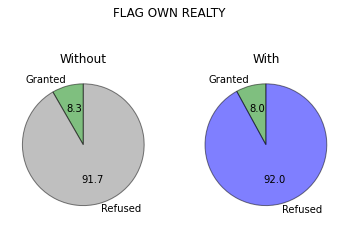

In [9]:
plot_customer_position(train_df, test_df, model, row, n_feat=12)